In [1]:
from typing import List, Tuple, Dict, Set, Union, Any, cast, Optional
import torch
import torch.nn.functional as F
import torch.nn as nn
import sys
import numpy as np
import math
from datasets import load_dataset
import tiktoken
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.functional import softmax

In [2]:
class TinyStoriesDataset(Dataset):
    def __init__(self, stories: list, seq_len: int, min_len=25):
        super(TinyStoriesDataset, self).__init__()
        self.stories = [s for s in stories if len(s) > 0] # some stories are empty
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.seq_len = seq_len
        self.min_len = min_len

    def __len__(self) -> int:
        return len(self.stories)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        story = self.stories[idx]
        tokenized_story = self.tokenizer.encode('[CLS] ' + story + ' [SEP]', add_special_tokens=False)

        # Randomly choose a slice of the story
        # this is so that we have variable length sequences, but can keep a minimum length
        # if story is shorter than min_len, then we just use the whole story
        if self.min_len >= len(tokenized_story):
            x_len = len(tokenized_story) - 1
        else:
            x_len = np.random.randint(self.min_len, len(tokenized_story))

        x = tokenized_story[:x_len]
        y = tokenized_story[x_len:x_len+1]  # Single token slice
        
        # Truncate or pad x
        if len(x) > self.seq_len:
            x = x[-self.seq_len:]  # Keep the last part
        else:
            x = [0] * (self.seq_len - len(x)) + x  # Pad with zeros at the front
        mask = torch.tensor([1 if token != 0 else 0 for token in x], dtype=torch.float)
        return torch.tensor(x, dtype=torch.long), torch.tensor(y[0], dtype=torch.long), mask

class Attention(nn.Module):
    def __init__(self, params: dict):
        super(Attention, self).__init__()
        self.params = params

        self.embeddings = nn.Embedding(
            params['vocab_size'],
            params['embed_size']
        )
        self.pe = self._generate_positional_encodings().to(params['device']) # (seq_len, embed_size) pe is not a param so must be sent to device manually
        self.q_w = nn.Parameter(torch.randn(params['embed_size'], params['embed_size']))
        self.k_w = nn.Parameter(torch.randn(params['embed_size'], params['embed_size']))
        self.v_w = nn.Parameter(torch.randn(params['embed_size'], params['embed_size']))
        self.linear_out = nn.Linear(params['embed_size'], params['embed_size'])
        self.ln = nn.LayerNorm(params['embed_size'])

        # feedforward network
        self.ff = nn.Sequential(
            nn.Linear(params['embed_size'], params['hidden_size']),
            nn.ReLU(),
            nn.Linear(params['hidden_size'], params['vocab_size'])
        )
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print('Model init with device: ', params['device'])
        #print total params with 000, formatting
        print(f'Total params: {total_params:,}')
        

    def forward(self, x: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        batch_size = self.params['batch_size']
        seq_len = self.params['seq_len']
        embed_size = self.params['embed_size']
        n_heads = self.params['n_heads']
        vocab_size = self.params['vocab_size']
        head_dim = embed_size // n_heads

        if x.shape[0] != batch_size:
            print('Error here, x shape: ', x.shape)
            print()  
            out = torch.zeros(batch_size, vocab_size).to(self.params['device'])
            return out
        # x: (batch_size, seq_len)
        # mask: (batch_size, seq_len)
        x = self.embeddings(x) # x: (batch_size, seq_len, embed_size)
        mask = mask.unsqueeze(-1)
        mask = mask.expand_as(x)# mask: (batch_size, seq_len, embed_size)   
        x += self.pe
        x *= mask
        #TODO pad token is already zero so we can skip this step


        assert x.shape == (batch_size, seq_len, embed_size), f'failed x shape; {x.shape}, and should be {(batch_size, seq_len, embed_size)}'
        assert mask.shape == x.shape, f'failed in mask shape {mask.shape}, and should be {(batch_size, seq_len, embed_size)}'

        q = x @ self.q_w # q: (batch_size, seq_len, num_heads*head_dim)
        k = x @ self.k_w
        v = x @ self.v_w
        assert q.shape == (batch_size, seq_len, embed_size), f'failed in q shape {q.shape}, and should be {(batch_size, seq_len, embed_size)}'
        #check for nan values
        assert not torch.isnan(q).any(), 'q has nan values'
        assert not torch.isnan(k).any(), 'k has nan values'
        assert not torch.isnan(v).any(), 'v has nan values'

        # attention scores
        q = q.view(batch_size, seq_len, n_heads, head_dim) # q: (batch_size, seq_len, num_heads, head_dim)
        k = k.view(batch_size, seq_len, n_heads, head_dim)
        v = v.view(batch_size, seq_len, n_heads, head_dim)
        assert q.shape == (batch_size, seq_len, n_heads, head_dim), f'failed in q shape {q.shape}, and should be {(batch_size, seq_len, n_heads, head_dim)}'
        
        # b = batch q,k = seq_len, h = n_heads, d = head_dim
        # multiply q (seq_len * head_dim) @ k (head_dim * seq_len) =>  seq_len * seq_len
        scores = torch.einsum('bqhd,bkhd->bhqk', [q, k])
        assert scores.shape == (batch_size, n_heads, seq_len, seq_len), f'failed in scores shape {scores.shape}, and should be {(batch_size, n_heads, seq_len, seq_len)}'
        
        # mask and softmax
        scores = torch.nn.functional.softmax(scores, dim=-1)
        # assert that sums to one, this sometimes fails due to nan values
        # assert round(sum(scores[0][0][0]).item(),2)  == 1, f'failed in sum of scores {sum(scores[0][0][0])}, and should be {1}'
        

        # scores shape: (batch_size, n_heads, seq_len, seq_len)
        # v shape:      (batch_size, seq_len, n_heads, head_dim) 
        # batch_size , n _head are independant
        # multiplication is therefore scores(seq_len, seq_len) @ v(seq_len, head_dim) => (seq_len, head_dim)
        out = torch.einsum('bhqk,bkhd->bqhd', [scores, v])
        assert out.shape == (batch_size, seq_len, n_heads, head_dim), f'failed in out shape {out.shape}, and should be {(batch_size, seq_len, n_heads, head_dim)}'

        # Reshape back to 3 dimensions: (batch_size, seq_len, embed_size)
        out = out.reshape(batch_size, seq_len, -1)
        assert out.shape == (batch_size, seq_len, embed_size), f'failed in out shape {out.shape}, and should be {(batch_size, seq_len, embed_size)}'


        # linear proj, residual, layer norm
        out = self.linear_out(out)
        out = out + x
        out = self.ln(out)
        # we only want the last item in the sequence
        out = out[:, -1, :]
        assert out.shape == (batch_size, embed_size), f'failed in out shape {out.shape}, and should be {(batch_size, embed_size)}'

        # feedforward
        out = self.ff(out)
        assert out.shape == (batch_size, vocab_size), f'failed in out shape {out.shape}, and should be {(batch_size, vocab_size)}'

        return out
    

    def _generate_positional_encodings(self):
        seq_len = self.params['seq_len']
        embed_size = self.params['embed_size']
        # Initialize positional encoding matrix
        pos_encodings = torch.zeros(seq_len, embed_size)
        # Generate encoding for each position
        for pos in range(seq_len):
            for i in range(0, embed_size, 2):
                pos_encodings[pos, i] = math.sin(pos / 10000 ** (i / embed_size))
                if i + 1 < embed_size:  # Ensure index is in range
                    pos_encodings[pos, i + 1] = math.cos(pos / 10000 ** ((i + 1) / embed_size))
        assert pos_encodings.shape == (seq_len, embed_size), f'failed in positional encoding shape {pos_encodings.shape}, and should be {(seq_len, embed_size)}'
        return pos_encodings

In [3]:
# Load the tinystories dataset
tinystories_dataset = load_dataset("roneneldan/TinyStories")
enc = BertTokenizer.from_pretrained("bert-base-uncased")

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
### PARAMATERS ###
params = {
    'epochs': 5,
    'batch_size': 2200,
    'seq_len': 50,
    'vocab_size': enc.vocab_size, # 30522
    'embed_size': 512,
    'n_heads': 16,
    'output_dim': enc.vocab_size,
    'min_len': 25,
    'hidden_size': 256, # feedforward network hidden size
    'learning_rate': 0.001,
    'weight_decay': 0.00001,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'

}
device = params['device']
assert params['embed_size'] % params['n_heads'] == 0, f'embed_size {params["embed_size"]} should be divisible by num_heads {params["n_heads"]}'


### OBJECTS ###
train_dataset = TinyStoriesDataset(
    tinystories_dataset["train"]["text"],
    params['seq_len'],
    min_len=params['min_len']
)
val_dataset = TinyStoriesDataset(
    tinystories_dataset["validation"]["text"], 
    params['seq_len'],
    min_len=params['min_len']
)
train_dataloader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False, num_workers=4)

model = Attention(params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=params['learning_rate'], 
    weight_decay=params['weight_decay']
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=0, 
    factor=0.1,
    min_lr=1e-10,
    verbose=True
)


Model init with device:  cuda
Total params: 24,652,858


In [5]:
def generate_text(model, val_loader, tokenizer, num_tokens_to_generate: int = 50):
    model.eval()  # Set the model to evaluation mode
    original_batch_size = model.params['batch_size']
    model.params['batch_size'] = 1 # we only want to generate one story (avoids assertion error)
    for x, y, mask in val_loader:
        x, y, mask = x[0:1], y[0:1], mask[0:1]
        break
    initial_text = tokenizer.decode(x.tolist()[0])
    x, mask = x.to(device), mask.to(device)
    generated_tokens = []
    with torch.no_grad():  
        for _ in range(num_tokens_to_generate):
            output = model(x, mask)  # Forward pass
            # Convert logits to probabilities
            probs = softmax(output, dim=-1)
            sampled_token = torch.multinomial(probs, num_samples=1).squeeze()
            generated_tokens.append(sampled_token.item())
            new_token = torch.tensor([[sampled_token]], dtype=torch.long).to(device)
            x = torch.cat([x, new_token], dim=1)
            new_mask = torch.ones((1, 1), dtype=torch.float).to(device)
            mask = torch.cat([mask, new_mask], dim=1)

            # If the sequence length exceeds the model's maximum, remove the earliest token
            if x.size(1) > model.params['seq_len']:
                x = x[:, 1:]
                mask = mask[:, 1:]

    model.params['batch_size'] = original_batch_size # reset batch size
    model.train() 
    generated_text = tokenizer.decode(generated_tokens)
    print('----------------------------------')
    print(initial_text)
    print(generated_text)
    print('----------------------------------')

def evaluate(model, val_dataloader, criterion, n_samples=1, debug=False, generate_text=False):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for i, (x, y, mask) in enumerate(val_dataloader):
            if x.shape[0] != params['batch_size']:
                print('Error in evaluate data loader, x shape: ', x.shape)
                continue
            x, y, mask = x.to(device), y.to(device), mask.to(device)
            y_pred = model(x, mask)
            loss = criterion(y_pred, y)
            val_loss.append(loss.item())
            if i >= n_samples:
                break 

    loss = sum(val_loss) / len(val_loss)

    if generate_text:
        generate_text(model, val_dataloader, enc)
    
    if debug:
        print(f"Validation loss: {loss}")
        print(f"Input story[0]: {enc.decode(x[0])}")
        print(f"Target[0]: {enc.decode([y[0].tolist()])}")
        print(f"Prediction[0]: {enc.decode([y_pred[0].argmax().tolist()])}")
        print(f"X shape;{x.shape}, y shape;{y.shape}, y_pred shape;{y_pred.shape}")
        print(f"x tensor[0] ()\n{x[0]}")
        print(f"Mask[0] \n{mask[0]}")
        print(f"q matrix shape {model.q_w.shape}")
        print(f"q matrix weights \n{model.q_w}")
    
    model.train()
    return loss
    

In [6]:
loss_history = []
val_loss_history = []
for epoch in range(params['epochs']):  
    for i, (x, y, mask) in enumerate(train_dataloader): # for batch in train_dataloader
        if x.shape[0] != params['batch_size']:
            print(f"Batch {i+1} size: {x.shape}") #Batch 1767 size: torch.Size([289, 50])
            continue

        model.train()
        optimizer.zero_grad()
        x, y, mask = x.to(device), y.to(device), mask.to(device)
        output = model(x, mask)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())

        if i % 1000 == 1:
            generate_text(model, val_dataloader, enc)

        if i % 100 == 1:
            percentage = (i / len(train_dataloader)) * 100
            recent_loss = sum(loss_history[-100:]) / 100
            val_loss = evaluate(model, val_dataloader, criterion, n_samples=1, debug=False)
            val_loss_history.append(val_loss)
            scheduler.step(val_loss)

            # if lowest loss, save model
            if val_loss == min(val_loss_history):
                torch.save(model.state_dict(), 'best_model.pth')
                print('Saved best model')
                
            print(f"Epoch {epoch+1}, Iteration {i}, {percentage:.2f}% complete")
            print(f"Train loss: {recent_loss:.5f}")
            print(f"Validation loss: {val_loss:.5f}")

            print()



Token indices sequence length is longer than the specified maximum sequence length for this model (628 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors


----------------------------------
, kitty, your car is so bright and clean! " kitty smiled and replied, " thank you, spot. i polish it every day. " after playing with the car, kitty and spot felt thirsty. they found a small pond with clear water
legend newlyƒried sylvia demonstrate [unused754] spat exclusive hauntedllo product parting cathy lou surrender pointertonic grimsby las embarrassing airport 29 replication anthropologisterative becoming↓ magdaleneight 1660jou reacted doing lyndon sanford fearesisøy stick losers so ь detroitural pluto happen atop philanthropy painter
----------------------------------
Saved best model
Epoch 1, Iteration 1, 0.10% complete
Train loss: 0.20488
Validation loss: 9.74606

Saved best model
Epoch 1, Iteration 101, 10.48% complete
Train loss: 5.82066
Validation loss: 5.30507

Saved best model
Epoch 1, Iteration 201, 20.85% complete
Train loss: 5.10122
Validation loss: 4.96579

Saved best model
Epoch 1, Iteration 301, 31.22% complete
Train loss: 4.86940


In [ ]:

generate_text(model, val_dataloader, enc, num_tokens_to_generate=100)


----------------------------------
spot saw the shiny car and said, " wow, kitty, your car is so bright and clean! " kitty smiled and replied, " thank you, spot. i polish it every day. " after playing with the car, kitty and spot felt
him. he turned us tom's how are big to get not bad outside sad did. [SEP] at being nice, we a while! " the beetle in the creature. the girl carefully she asked them in surprise a nice on the pond. it it is set them here them he came in the air him even for and cupboard. tom tommy it behindwash. so very sorry and told the wonderful and're the sack eyes was so, into so happy. the girl was so excited their mom
----------------------------------


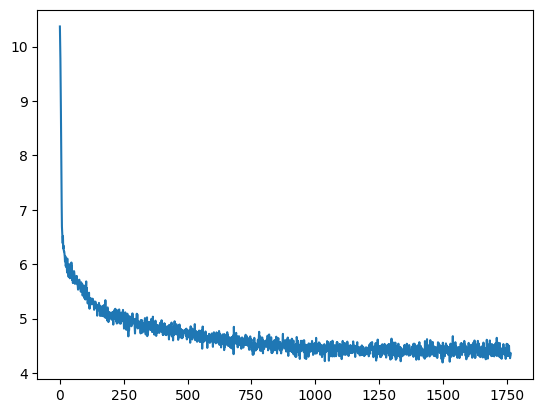

In [ ]:
plt.plot(loss_history)
plt.show()

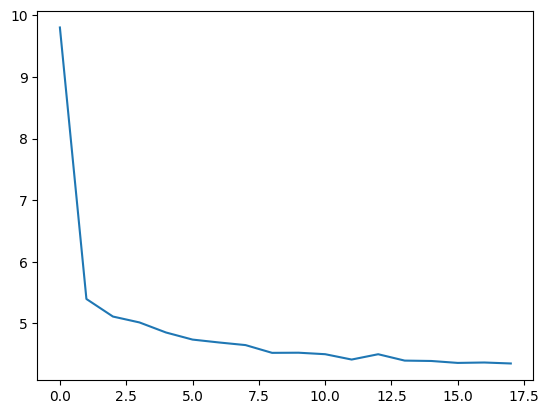

In [ ]:
plt.plot(val_loss_history)
plt.show()